In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
from ParticlePlotFunctions import *
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


# NEMO-MEDUSA info

5-day means from 01-05-2000 until 31-12-2010

In [ ]:
# plot SST + quiver of specific date

ddir = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/'
ddate = 20000110
map_crop = [2000, 3001, 1000, 2001]

Field = ReadNemo(ddir,ddate)
lon = Field['lon']
lat = Field['lat']
Uvel = Field['Uvel']
Vvel = Field['Vvel']
Tvel = Field['Tvel']

PlotSSTquiver(lon,lat,Tvel,Uvel,Vvel)
plt.savefig('../../results/figures/NEMO_SSTquiver_20000105.pdf')

In [4]:
# read bathymetry 

latdim = np.arange(1000,2001)
londim = np.arange(2000,3001)

bathy_file = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/domain/bathymetry_ORCA12_V3.3.nc'
dfile = Dataset(bathy_file)
bathy = dfile.variables['Bathymetry'][latdim,londim]
lat = dfile.variables['nav_lat'][latdim,londim]
lon = dfile.variables['nav_lon'][latdim,londim]
bathy = np.where(bathy<1, nan, bathy)

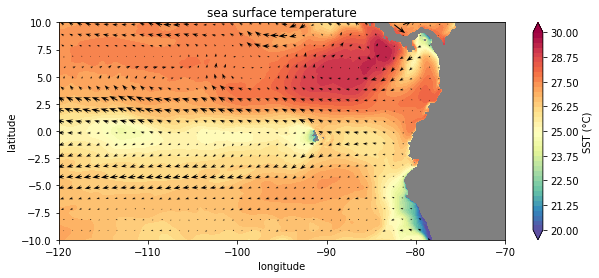

In [2]:
# read multiple fields and compute mean

ddir = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/'
ddates = range(300,310)
nz = 2
map_crop = [2000, 3001, 1000, 2001]

Field = ReadNemoMean(ddir, ddates, nz, map_crop)
lon = Field['lon']
lat = Field['lat']
Umean = Field['Umean']
Vmean = Field['Vmean']
Tmean = Field['Tmean']

PlotSSTquiver(lon,lat,Tmean,Umean,Vmean,figsize=(10,4))

In [ ]:
# makes figure with four panels for U, V, speed and SST

Uvel = Umean
Vvel = Vmean
Tvel = Tmean

map_extent = [-120,-70,-10,10]
speed = np.sqrt(Uvel**2 + Vvel**2)

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

levels = np.linspace(-0.5, 0.5, 21)
fig1 = ax[0,0].contourf(lon,lat,Uvel,       
                        levels = levels,    
                        cmap='RdBu_r',       
                        extend='both',      
                        origin='lower')     
ax[0,0].set_title('eastward velocity')          
#ax[0,0].set_xlabel('longitude')                 
ax[0,0].set_ylabel('latitude') 
ax[0,0].set_xlim(map_extent[0:2])
ax[0,0].set_ylim(map_extent[2:4])
ax[0,0].set_facecolor('gray')
cbar = plt.colorbar(fig1, ax=ax[0,0])
cbar.ax.set_ylabel('U (m/s)')  

levels = np.linspace(-0.5, 0.5, 21)
fig2 = ax[0,1].contourf(lon,lat,Vvel,       
                        levels = levels,    
                        cmap='RdBu_r',       
                        extend='both',      
                        origin='lower')     
ax[0,1].set_title('northward velocity')          
#ax[0,1].set_xlabel('longitude')                 
#ax[0,1].set_ylabel('latitude') 
ax[0,1].set_xlim(map_extent[0:2])
ax[0,1].set_ylim(map_extent[2:4])
ax[0,1].set_facecolor('gray')
cbar = plt.colorbar(fig2, ax=ax[0,1])
cbar.ax.set_ylabel('V (m/s)') 

levels = np.linspace(20, 30, 41)
fig2 = ax[1,1].contourf(lon,lat,Tvel,       
                        levels = levels,    
                        cmap='Spectral_r',       
                        extend='both',      
                        origin='lower')     
ax[1,1].set_title('sea surface temperature')          
ax[1,1].set_xlabel('longitude')                 
#ax[1,1].set_ylabel('latitude') 
ax[1,1].set_xlim(map_extent[0:2])
ax[1,1].set_ylim(map_extent[2:4])
ax[1,1].set_facecolor('gray')
cbar = plt.colorbar(fig2, ax=ax[1,1])
cbar.ax.set_ylabel('SST') 

levels = np.linspace(0, 1, 21)
fig2 = ax[1,0].contourf(lon,lat,speed,       
                        levels = levels,    
                        cmap='YlOrBr',       
                        extend='both',      
                        origin='lower')     
ax[1,0].set_title('speed')          
ax[1,0].set_xlabel('longitude')                 
ax[1,0].set_ylabel('latitude') 
ax[1,0].set_xlim(map_extent[0:2])
ax[1,0].set_ylim(map_extent[2:4])
ax[1,0].set_facecolor('gray')
cbar = plt.colorbar(fig2, ax=ax[1,0])
cbar.ax.set_ylabel('speed (m/s)')

plt.savefig('../../results/figures/NEMOfields_mean2000.pdf')